In [1]:
%matplotlib inline


# DCGAN


## Giriş
## Generative Adversarial Networks

### GAN'lar deyince ne anlamamız gerekir?

GAN'lar bir derin öğrenme modeli eğitilirken verilerin içindeki desenlerin dağılımını öğrenmeye çalışır. Böylece gürültü ya da farklı bir kaynaktan gelen rastgele bir veriden input da verilen veri gibi veriler üretilebilir.
GAN'lar 2014 yılında Ian Goodfellow tarafından icat edilmiştir. Orjinal makalesine buradan erişebilirsiniz.
[Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)_.
GAN'ların yapıtaşında şöyle bir mimari bulunur.
Bir *jeneratör* ve bir
*ayrımcı*. Jeneratörün işi, "sahte" görüntüler oluşturmaktır.(aslında bu bizim eğitim görüntümüz olacaktır.)Ayrımcının işi ise
gerçek bir eğitim görüntüsü ve
jeneratörden gelen sahte görüntü arasındaki farka bakmaktır. Aslında GAN'lar iki farklı ağdır. Bunlar sürekli olarak birbirini kandırmaya çalışır. Eğitim sırasında, jeneratör
sürekli olarak daha iyi ve daha iyi üreterek ayrımcıyı alt etmeye çalışmak için uğraşır.
Ayrımcı daha ise ayrımı daha iyi yapmak adına mücadele verir. Bu oyunun dengesi, jeneratörün mükemmel şekilde yani ayrımcının iki veriyi ayıramayacak şekilde bir veri ürettiğinde son bulur..

### Peki DCGAN?

Bir DCGAN, yukarıda açıklanan GAN'ın doğrudan bir uzantısıdır, ancak bunun dışında
açıkça evrişimli ve evrişimli-devrik katmanları kullanır.
İlk olarak Radford et. al. tarafından makalesi ile duyrulmuştur.[Denetimsiz Temsili Öğrenim
Derin Konvolüsyon Üretken Hasım
Ağlar](https://arxiv.org/pdf/1511.06434.pdf)_.
ayrımcı uzun adımlardan oluşur, ve bu adımlara ait makaleler şu şekildedir.
[evrişim](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d)_
katmanlar, [toplu
norm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d)_
katmanlar ve
[LeakyReLU](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU)_ aktivasyonu.
Giriş bir 3x64x64 giriş görüntüsüdür ve çıkış bir
girdinin gerçek veri dağılımından olduğuna dair skaler olasılık.
Jeneratör şunlardan oluşur:
[evrişimli devrik](https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d)_
katmanlar, batch_norm katmanları ve
[ReLU](https://pytorch.org/docs/stable/nn.html#relu)_ aktivasyonlar.


In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# tekrar üretilebilirlik için
manualSeed = 999
#manualSeed = random.randint(1, 10000) # eğer yeni sonuçlar istiyorsak kullanabiliriz.
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Girişler.

bazı terimlere açıklık getirelim.

-  **dataroot** - veri kümesi klasörünün köküne giden yol
-  **workers** - dataloader'dan verileri yüklemek için çalışan iş parçacığı sayısı
-  **batch_size** - eğitimde kullanılan parti boyutu.DCGAN için makalesinde 128 kullanılması tavsiye edilmiştir.
-  **image_size** - Bu uygulama varsayılan olarak 64x64'tür. Başka bir boyut istenirse, D ve G yapılarında değişiklik yapılmalıdır.
(https://github.com/pytorch/examples/issues/70)
-  **nc** - giriş görüntülerindeki renk kanallarının sayısı( varsayılan olarak 3 ayarlayacağız.)
-  **nz** - gizli vektörün uzunluğu
-  **ngf** - jenarator aracılığıyla taşınan özellik haritalarının derinliği ile ilgilidir.
-  **ndf** - ayrımca aracılığıyla yayılan özellik haritalarının derinliğini ayarlar.
-  **num_epochs** - çalışacak eğitim sayısı, gpu 'suna güvenen sayıyı artırsın :)
-  **lr** - öğrenme oranı. DCGAN makalesinde 0,0002 yap denilmiştir.
-  **beta1** - ADAM optimizer'in hiper parametresi, 0.5 olarak kullanacağız
-  **ngpu** - GPU varsa CUDA üzerinden işleme devam edeceğiz.




In [3]:
# Veri kümesi için kök dizin
dataroot = "data/celeba"

#Veri yükleyici için çalışan sayısı
workers = 2

# Batch size 
batch_size = 128

image_size = 64

# renki kanal sayısı
nc = 3

# üretici girişinin boyutu
nz = 100

# Oluşturucudaki özellik haritalarının boyutu
ngf = 64

# Ayrımcıdaki özellik haritalarının boyutu
ndf = 64

# kaç epochs çalışacağız
num_epochs = 5

# Learning rate 
lr = 0.0002

beta1 = 0.5

ngpu = 1

## Veri
[Celeb-A Faces
dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html),[Google
Drive](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg)_.
Veri kümesi *img_align_celeba.zip* adlı bir dosya olarak indirilecektir, indirdikten sonra *celeba* adında bir dizin oluşturun ve zip dosyasını çıkartın,Ardından, bu not defteri için *dataroot* girişini yukarıda yazdğımız gibi ayarlayalım.


In [ ]:
%%shell

# download 
wget https://cseweb.ucsd.edu/~weijian/static/datasets/celeba/img_align_celeba.zip .
# extract 
unzip img_align_celeba.zip

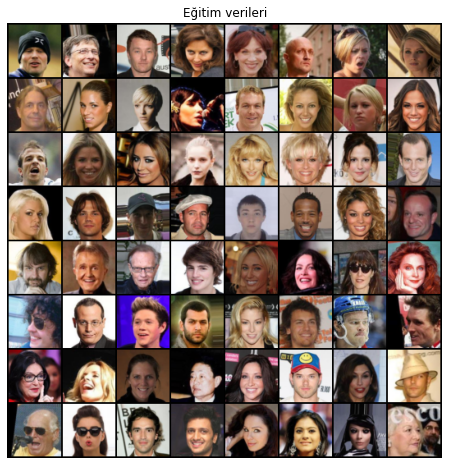

In [5]:
# Bir resim klasörü veri setini, kurulumunu yaptığımız şekilde kullanabiliriz.
# Veri kümesini oluştur
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# varsa gpu üzerinden devam edeceğiz 
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Bazı eğitim görüntüleri çizin
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Eğitim verileri")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## uygulama
### Ağırlık başlatma
DCGAN makalesine uygun şekilde ağırlıkları başlatacağız.




In [6]:
# özel ağırlık başlatma, bu kısım makalede böyle geçiyor.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [7]:
# Generator

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # giriş olan Z conv katmanına gider.
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# generator'oluşturalım
netG = Generator(ngpu).to(device)

# eğer varsa çoklu gpu kullanabiliriz.
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Tüm ağırlıkları rastgele başlatmak için ağırlıklar_init işlevini uygulayalım
# mean=0, stdev=0.02.
netG.apply(weights_init)

# modeli yazdıralım
print(netG)

### Discriminator



In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Discriminator' oluşturalım
netD = Discriminator(ngpu).to(device)

# varsa çoklu gpu kullanabiliriz.
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# ağırlıkları yazdığımız fonksiyon göre rastgele başlatalım.
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# modelimizi yazdıralım.
print(netD)

### Loss Functions ve Optimizers
Binary CrossEntropy loss kullanacağız.
([BCELoss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)_)

Ve hesaplama fonksiyonumuz şu şekilde olacakt

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}






In [11]:
# loss fonksiyonumuz
criterion = nn.BCELoss()

# üreticinin ilerlemesini görselleştirmek için kullanacağımız özellik vektörümüzü oluşturalım.
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Eğitim sırasında gerçek ve sahte etiketler için kural oluşturun
real_label = 1.
fake_label = 0.

# D ve G için opt'imleri ayarlayalım.
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Eğitim

Son olarak, artık GAN çerçevesinin tüm parçalarını tanımladığımıza göre,
onu eğitebiliriz. GAN'ları eğitmenin biraz sanat olduğunu unutmayın
yanlış hiperparametre ayarları modun çökmesine neden olduğundan
neyin yanlış gittiği iyi takip etmek gerekir. Bunun için şu makaleye bir göz atın [ganhacks](https://github.com/soumith/ganhacks)

**1. Bölüm - Ayrımcıyı Eğitin**

Hatırlayın, ayrımcıyı eğitmenin amacı,
Belirli bir girdiyi gerçek veya sahte olarak doğru bir şekilde sınıflandırma olasılığı bulmaktı.. Yani kısaca, “ayrımcının iyiliğini yükselterek güncellemek istiyoruz, stokastik gradyanı kullanarak.”Daha matematiksel olmak gerekirse, maksimize etmek istiyoruz -->
$log(D(x)) + log(1-D(G(z)))$. Ayrı mini parti nedeniyle
ganhacks'ten gelen öneri, bunu iki adımda hesaplayacağız. Önce biz
eğitim setinden bir dizi gerçek örnek oluşturacak, ileri
$D$'den geçin, kaybı hesaplayın ($log(D(x))$), ardından
geriye doğru geçişte gradyanları hesaplayın. İkincisi, inşa edeceğiz
mevcut üreteç ile bir grup sahte numune, bunu iletin
$D$ üzerinden toplu iş yapın, kaybı hesaplayın ($log(1-D(G(z))))$),
ve geriye doğru geçişle eğimleri *toplayın*.
Hem gerçek hem de tamamen sahte partilerden toplanan gradyanları, ayrımcının opt'imine verelim..

**2. Bölüm - Jeneratörü Eğitin**

Orijinal belgede belirtildiği gibi, Jeneratörü şu şekilde eğitmek istiyoruz:
daha iyi sahteler oluşturmak için $log(1-D(G(z)))$'ı en aza indirmek.
Bahsedildiği gibi, bunun yeterli şekilde sağlamadığı Goodfellow tarafından gösterildi, özelikle gradyanlar öğrenme sürecinin başlarında pek etkili olamadılar.. Düzeltme olarak biz
bunun yerine $log(D(G(z))))$'yi maksimize etmek istiyoruz. Yaptığımız kodda bunu: Kısım 1'deki Jeneratör çıktısını şu şekilde sınıflandırarak:
Ayrımcı, G'nin kaybını hesaplama *GT olarak gerçek etiketleri kullanarak*, hesaplama
Geriye geçişte G'nin gradyanları ve son olarak G'nin parametrelerinin güncellenmesini bir optimize edici adım ile yaparak. Gerçeği kullanmak mantığa aykırı görünebilir.Kayıp işlevi için GT etiketleri olarak kullanır, ancak bu,
BCELoss'un $log(x)$ kısmı ($log(1-x)$ yerine
kısmı) tam olarak istediğimiz şey.


-  **Loss_D** - tüm gerçek ve tüm sahte gruplar için ayrımcı kaybı ($log(D(x)) + log(1 - D(G(z)))$)
-  **Loss_G** - $log(D(G(z)))$ olarak hesaplanan jeneratör kaybı
-  **D(x)** - ayrımcının ortalama çıktısı (parti boyunca)
    tüm gerçek parti için. Bu 1'e yakın başlamalı o zaman
    G iyileştiğinde teorik olarak 0,5'e yakınsar.
-  **D(G(z))** - Tümü sahte parti için ortalama ayrımcı çıktıları.
    İlk sayı, D güncellenmeden önceki sayıdır ve ikinci sayı,
    D güncellendikten sonra. Bu sayılar 0'a yakın başlamalı ve
    G iyileştikçe 0,5.





In [ ]:
# Eğitim döngüsü

# İlerlemeyi takip etmek için listeler
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Eğitim döngüsü başlatıyoruz...")
# her epoch için
for epoch in range(num_epochs):
    # Veri yükleyicideki her parti için
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) D ağını güncelle amacın maksimize etmek olsun: log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## tamamen gerçek veriler ile işlem yapıyoruz.
        netD.zero_grad()
        # toplu biçimlendirme.
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # gerçek veriyi D 'ye iletelim.
        output = netD(real_cpu).view(-1)
        # gerçek veri üzerindeki loss u hesaplayalım.
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## tamamen sahte veriler ile işlem yapıyoruz.
        # Gizli vektörler grubu oluştur
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # G LE sahte görüntüleri oluşturalım
        fake = netG(noise)
        label.fill_(fake_label)
        # G ile üretilen sahte verileri D ile sınıflandır
        output = netD(fake.detach()).view(-1)
        # D'nin kaybını sahte veri batchlerine göre hesaplayın
        errD_fake = criterion(output, label)
        # Önceki gradyanlarla birikmiş (toplanmış) bu parti için gradyanları hesapla
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Sahte ve gerçek partilerin toplamı olarak D'nin hesaplama hatası
        errD = errD_real + errD_fake
        # D'yi güncelle.
        optimizerD.step()

        ############################
        # (2) G ağını güncelleyelim ve onu maximize etmeye çalışalım -- > log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # sahte etiketler jeneratör maliyeti için gerçektir
        # D'yi yeni güncellediğimizden, tamamı sahte toplu iş için D'den başka bir ileri geçiş gerçekleştirin
        output = netD(fake).view(-1)
        # Bu çıktıya dayalı olarak G'nin kaybını hesaplayın
        errG = criterion(output, label)
        # G için gradyanları hesapla
        errG.backward()
        D_G_z2 = output.mean().item()
        # G'yi güncelle
        optimizerG.step()
        
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Daha sonra çizmek için Kayıpları Kaydet
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # G'nin çıktısını sabit_noise'a kaydederek jeneratörün nasıl çalıştığını kontrol edin
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

## Sonuçlar

Son olarak, nasıl yaptığımıza bir göz atalım. Burada üç farklı sonuca bakacağız. İlk olarak, eğitim sırasında D ve G'nin kayıplarının nasıl değiştiğini göreceğiz. İkinci olarak, G'nin çıktısını her dönem için sabit_noise toplu işinde görselleştireceğiz. Üçüncüsü, G'den gelen bir grup sahte verinin yanında bir grup gerçek veriye bakacağız.

Eğitim yinelemesine karşı kayıp

Aşağıda, D & G'nin eğitim yinelemelerine karşı kayıplarının bir grafiği bulunmaktadır.



In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator ve Discriminator'ün Eğitim Sırasındaki Kaybı")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**G'nin ilerlemesinin görselleştirilmesi**

Her eğitim döneminden sonra sabit_noise grubunda jeneratörün çıktısını nasıl kaydettiğimizi hatırlayın. Şimdi, G'nin eğitim ilerlemesini bir animasyonla görselleştirebiliriz. Animasyonu başlatmak için oynat düğmesine basın.



In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Gerçek Görüntüler ve Sahte Görüntüler**

Son olarak, bazı gerçek görüntülere ve sahte görüntülere yan yana bakalım.


In [ ]:
# Veri yükleyiciden bir dizi gerçek görüntü alın
real_batch = next(iter(dataloader))

# Gerçek görüntüleri çizin
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("GERÇEK")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Son dönemdeki sahte görüntüleri çizinh
plt.subplot(1,2,2)
plt.axis("off")
plt.title("SAHTE")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()